In [4]:
import matplotlib.pyplot as plt
import glob
import numpy as np
from scipy import stats
import json
from textblob import TextBlob

In [5]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D, RepeatVector
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.layers.wrappers import Bidirectional
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.initializers import *

Using TensorFlow backend.


# Preprocess Price Data

In [2]:
for file in glob.glob("stocknet-dataset/price/preprocessed/*"):
    name = file.split("\\")[1]
    with open("stocknet-dataset/price/preprocessed/"+name, "r") as infile, open("price/" + name, "w+") as outfile:
        for line in infile:
            value = line.split("\t")
            outfile.write(value[0]+ " "+ value[-2] + " \n")

# Read Price Data

In [100]:
vals_p = []
with open("price/AAPL.txt") as infile:
    for line in infile:
        value = line.split(" ")[:2]
        vals_p.append(value)

vals_p[0] => array of dates
vals_p[1] => array of closing price

In [101]:
vals_p = np.array(vals_p)
vals_p = vals_p.T
vals_p = np.flip(vals_p)
vals_p = np.flip(vals_p, 0)

In [109]:
dates_p = np.array(vals_p[0], np.datetime64)
dates_p.shape

(1257,)

In [110]:
price = vals_p[1].astype(np.float)
zprice = stats.zscore(price)

In [111]:
p = price.tolist()
d_p = dates_p.tolist()

In [112]:
i = 1
while (i < len(d_p)):
    di = np.datetime64(d_p[i-1]) + 1
    if(d_p[i] != di):
        x = (p[i-1] + p[i])/2
        d_p.insert(i, di)
        p.insert(i,x)
        i -= 1
    i += 1

In [113]:
price = np.array(p, np.float)
dates_p = np.array(d_p, np.datetime64)

In [107]:
with open("price/" + "AAPL" + " pp.txt", "w+") as outfile:
    for d, p in zip(dates_p, price):
        outfile.write(str(d)+ " "+ repr(p) + " \n")

In [117]:
dates_p = dates_p[483:1304]

In [153]:
price = price[483:1304]

# Plot Stock Price

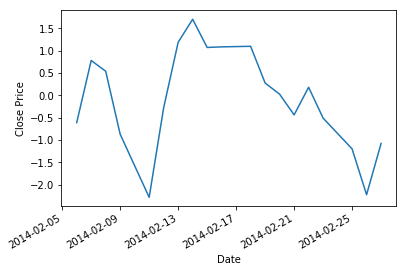

In [36]:
plt.plot(dates_p[:22], price[:22].astype(np.float))
plt.gcf().autofmt_xdate()
plt.xlabel('Date')  
plt.ylabel('Close Price')
plt.show()

# Preprocess Tweets Data

In [84]:
for file in glob.glob("stocknet-dataset/tweet/raw/AAPL/*"):
    name = file.split("\\")[1]
    with open("stocknet-dataset/tweet/raw/AAPL/"+name, "r") as infile, open("sentiment/AAPL.txt", "a+") as outfile:
        tweets = []
        for line in infile:
            t = json.loads(line)
            tweet = {"text": t["text"], "weight": t["favorite_count"] + t["retweet_count"] + 1}
            tweets.append(tweet)
            
        # pos, neg, ntrl
        sntmnt = [0, 0, 0]
        for tweet in tweets:
            t = TextBlob(tweet["text"])
            if t.sentiment[0]>0:
               sntmnt[0] += tweet["weight"]
            elif t.sentiment[0]<0:
               sntmnt[1] += tweet["weight"]
            else:
               sntmnt[2] += tweet["weight"]
        i = np.argmax(sntmnt)
        if(i == 0):
            o = 1
        elif(i == 1):
            o = -1
        else:
            o = 0
        outfile.write(name.split(".")[0] + " " + repr(o) + " \n")

In [85]:
vals_s = []
with open("sentiment/AAPL.txt") as infile:
    for line in infile:
        value = line.split(" ")[:2]
        vals_s.append(value)

sentiment => sentiment value  1-> positive, -1-> negative, 0-> neutral

In [86]:
vals_s = np.array(vals_s)
vals_s = vals_s.T
dates_s = np.array(vals_s[0], np.datetime64)
sentiment = vals_s[1].astype(np.int)

In [87]:
ds = dates_s.tolist()
p = sentiment.tolist()

In [89]:
i = 1
while (i < len(ds)):
    di = np.datetime64(ds[i-1]) + 1
    if(ds[i] != di):
        ds.insert(i, di)
        p.insert(i,0)
        i -= 1
    i += 1

In [90]:
dates_s = np.array(ds, np.datetime64)
sentiment = np.array(p, np.int)

# Plot Twitter Sentiment

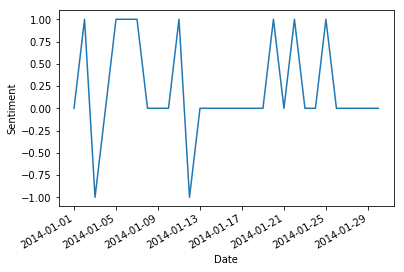

In [92]:
plt.plot(dates_s[:30], sentiment[:30])
plt.gcf().autofmt_xdate()
plt.xlabel('Date')  
plt.ylabel('Sentiment')
plt.show()

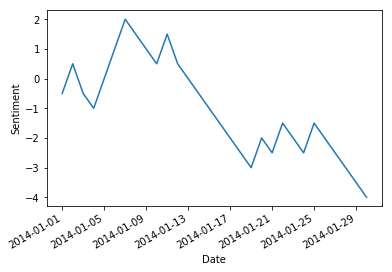

In [166]:
yar = []
y = 0
for s in sentiment:
    y += s
    if(s == 0):
        y -= 0.5
    yar.append(y)
zyar = stats.zscore(yar)
plt.plot(dates_s[:30], yar[:30])
plt.gcf().autofmt_xdate()
plt.xlabel('Date')  
plt.ylabel('Sentiment')
plt.show()

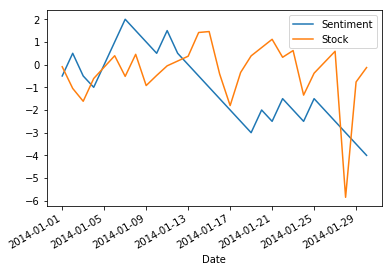

In [167]:
plt.plot(dates_s[:30], yar[:30], label = "Sentiment")
plt.plot(dates_p[:30], price[:30], label = "Stock")
plt.gcf().autofmt_xdate()
plt.xlabel('Date')  
plt.legend()
plt.show()

# Prediction

In [13]:
WINDOW = 30
EMB_SIZE = 2
STEP = 1
FORECAST = 1

In [544]:
X, Y = [], []
for i in range(0, dates_p.shape[0], STEP): 
    try:
        p = price[i:i+WINDOW]
        yar = []
        y = 0
        for s in range(i, i+WINDOW):
            y += sentiment[s]
            if(sentiment[s] == 0):
                y -= 0.65
            yar.append(y)

        p = stats.zscore(p)
        yar = stats.zscore(yar)

        x_i = price[i:i+WINDOW]
        y_i = price[i+WINDOW+FORECAST]  

        last_close = x_i[-1]
        next_close = y_i

        if last_close < next_close:
            y_i = [1, 0]
        else:
            y_i = [0, 1] 

        x_i = np.column_stack((p, yar))

    except Exception as e:
        break
        
    X.append(x_i)
    Y.append(y_i)

In [545]:
X, Y = np.array(X), np.array(Y)

In [546]:
def shuffle_in_unison(a, b):
    # courtsey http://stackoverflow.com/users/190280/josh-bleecher-snyder
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b
 
def create_Xt_Yt(X, y, percentage=0.95):
    p = int(len(X) * percentage)
    X_train = X[0:p]
    Y_train = y[0:p]
     
    #X_train, Y_train = shuffle_in_unison(X_train, Y_train)
 
    X_test = X[p:]
    Y_test = y[p:]

    return X_train, X_test, Y_train, Y_test

In [547]:
X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y)

In [548]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], EMB_SIZE))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], EMB_SIZE))

In [14]:
model = Sequential()
model.add(Convolution1D(input_shape = (WINDOW, EMB_SIZE),
                        nb_filter=16,
                        filter_length=4,
                        border_mode='same'))
model.add(BatchNormalization())
model.add(Activation('tanh'))
model.add(Dropout(0.5))

model.add(Convolution1D(nb_filter=8,
                        filter_length=4,
                        border_mode='same'))
model.add(BatchNormalization())
model.add(Activation('tanh'))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation('tanh'))


model.add(Dense(2))
model.add(Activation('softmax'))

d:\ahmed\python\test\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(kernel_size=4, padding="same", filters=16, input_shape=(30, 2))`
  """


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


d:\ahmed\python\test\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(filters=8, kernel_size=4, padding="same")`
  if sys.path[0] == '':


In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 30, 16)            144       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 16)            64        
_________________________________________________________________
activation_1 (Activation)    (None, 30, 16)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 16)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 30, 8)             520       
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 8)             32        
_________________________________________________________________
activation_2 (Activation)    (None, 30, 8)             0         
__________

In [584]:
opt = Nadam(lr=0.002)

In [585]:
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=30, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="lolkek.hdf5", verbose=1, save_best_only=True)

In [586]:
model.compile(optimizer=opt, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [587]:
history = model.fit(X_train, Y_train, 
          nb_epoch = 50, 
          batch_size = 128, 
          verbose=1, 
          validation_data=(X_test, Y_test),
          callbacks=[reduce_lr, checkpointer],
          shuffle=True)

d:\ahmed\python\test\lib\site-packages\ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys


Train on 750 samples, validate on 40 samples
Epoch 1/50
750/750 [==============================] - 9s 13ms/step - loss: 0.8230 - acc: 0.5093 - val_loss: 0.7577 - val_acc: 0.5250

Epoch 00001: val_loss improved from inf to 0.75774, saving model to lolkek.hdf5
Epoch 2/50
750/750 [==============================] - 0s 424us/step - loss: 0.7206 - acc: 0.5920 - val_loss: 0.7737 - val_acc: 0.5250

Epoch 00002: val_loss did not improve from 0.75774
Epoch 3/50
750/750 [==============================] - 0s 420us/step - loss: 0.6981 - acc: 0.5880 - val_loss: 0.7745 - val_acc: 0.5250

Epoch 00003: val_loss did not improve from 0.75774
Epoch 4/50
750/750 [==============================] - 0s 394us/step - loss: 0.6907 - acc: 0.5933 - val_loss: 0.7509 - val_acc: 0.5250

Epoch 00004: val_loss improved from 0.75774 to 0.75085, saving model to lolkek.hdf5
Epoch 5/50
750/750 [==============================] - 0s 432us/step - loss: 0.6802 - acc: 0.5867 - val_loss: 0.7343 - val_acc: 0.5500

Epoch 00005: va

In [588]:
model.load_weights("lolkek.hdf5")
pred = model.predict(np.array(X_test))

In [589]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [590]:
C = confusion_matrix([np.argmax(y) for y in Y_test], [np.argmax(y) for y in pred])

print(C / C.astype(np.float).sum(axis=1))

[[0.83333333 0.13636364]
 [0.5        0.59090909]]


In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return cm

[[0.83333333 0.13636364]
 [0.5        0.59090909]]


array([[0.83333333, 0.13636364],
       [0.5       , 0.59090909]])

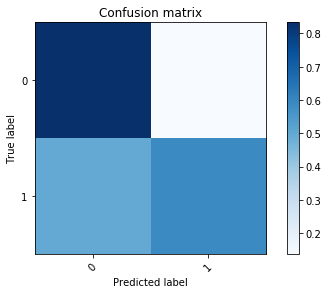

In [11]:
plot_confusion_matrix(C, [0, 1])

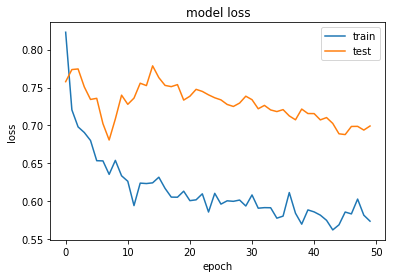

In [591]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

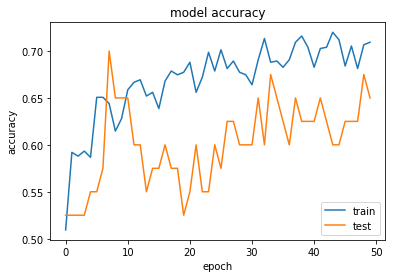

In [592]:
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [593]:
max(history.history['val_acc'])

0.699999988079071